<a href="https://colab.research.google.com/github/dctime/minecraft-texture-generation/blob/main/texture_generator_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#change id when next generation
id = 2

In [4]:
try:
  import shutil

  shutil.rmtree(f'images_{id}')
except:
  pass

import os
# create new single directory
os.mkdir(f'images_{id}')

In [5]:
import tensorflow as tf
try:
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
  print('Found GPU at: {}'.format(device_name))
except:
  print("no gpu")

no gpu


In [33]:
import zipfile
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D
from tensorflow.keras import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
import os
from keras.models import load_model
from tensorflow.keras.layers import MaxPooling2D
np.set_printoptions(floatmode='fixed')
tf.config.run_functions_eagerly(True)
print(tf.__version__)
print("Eager execution:", tf.executing_eagerly())
tf.data.experimental.enable_debug_mode()

2.12.0
Eager execution: True


In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
with zipfile.ZipFile('drive/MyDrive/Minecraft Texture Generator/minecraft_texture_with_resized_16.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')

In [82]:
# for filename in os.listdir('dataset/minecraft_texture_with_resize_16'):
#     print(filename)

In [83]:
# ds = tf.keras.preprocessing.image_dataset_from_directory('/content/dataset', image_size=(16, 16), batch_size=1)
train_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/dataset',
    batch_size=64,
    image_size=(16, 16),
    label_mode = None,
    color_mode = "rgba")
# train_dataset = tf.keras.utils.image_dataset_from_directory(
#     '/content/dataset',
#     validation_split=0.05,
#     subset='training',
#     seed=400,
#     image_size=(16, 16),
#     batch_size=64,
#     label_mode = None,
#     color_mode = "rgba")

# validation_dataset = tf.keras.utils.image_dataset_from_directory(
#     '/content/dataset',
#     validation_split=0.05,
#     subset='validation',
#     seed=400,
#     image_size=(16, 16),
#     batch_size=64,
#     label_mode = None,
#     color_mode = "rgba")


print(train_dataset)

Found 39461 files belonging to 1 classes.
<_BatchDataset element_spec=TensorSpec(shape=(None, 16, 16, 4), dtype=tf.float32, name=None)>


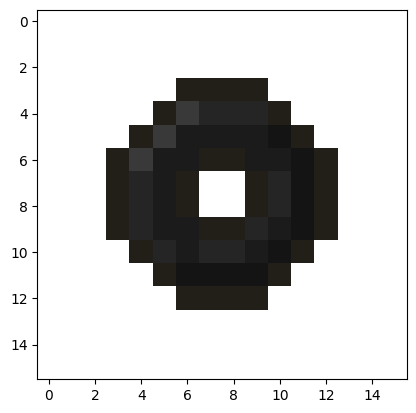

In [84]:
for images in train_dataset:
  image = images[0]
  plt.imshow(image.numpy().astype("uint8"))
  plt.show()
  break

In [85]:
def scale_img(img_ndarray):
  processing = img_ndarray
  return processing/255


train_dataset = train_dataset.map(scale_img)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(buffer_size=128)
train_dataset = train_dataset.prefetch(buffer_size=128)
print(train_dataset)


<_ShuffleDataset element_spec=TensorSpec(shape=(None, 16, 16, 4), dtype=tf.float32, name=None)>


In [42]:
def build_generator():
  model = Sequential()

  model.add(Dense((4*4*256), input_dim=128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((4, 4, 256)))


  model.add(Conv2D(256, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(64, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(32, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(UpSampling2D())
  model.add(Conv2D(16, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(8, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(4, 5, padding='same', activation='sigmoid'))


  return model

In [43]:
build_generator().summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 4096)              528384    
                                                                 
 leaky_re_lu_106 (LeakyReLU)  (None, 4096)             0         
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_110 (Conv2D)         (None, 4, 4, 256)         1638656   
                                                                 
 leaky_re_lu_107 (LeakyReLU)  (None, 4, 4, 256)        0         
                                                                 
 up_sampling2d_2 (UpSampling  (None, 8, 8, 256)        0         
 2D)                                                             
                                                     

In [46]:
def build_discriminator():
  # input 16x16x3
  model = Sequential()

  model.add(Conv2D(1, 8, padding='same', input_shape = (16, 16, 4)))
  model.add(LeakyReLU(0.3))
  model.add(Dropout(0.4))

  model.add(Conv2D(2, 8, padding='same'))
  model.add(LeakyReLU(0.3))
  model.add(Dropout(0.4))

  model.add(Conv2D(4, 8, padding='same'))
  model.add(LeakyReLU(0.3))
  model.add(Dropout(0.4))

  model.add(Conv2D(8, 5, padding='same'))
  model.add(LeakyReLU(0.3))
  model.add(Dropout(0.4))

  model.add(Conv2D(16, 5, padding='same'))
  model.add(LeakyReLU(0.3))
  model.add(Dropout(0.4))
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(32, 5, padding='same'))
  model.add(LeakyReLU(0.3))
  model.add(Dropout(0.4))

  model.add(Conv2D(64, 3, padding='same'))
  model.add(LeakyReLU(0.3))
  model.add(Dropout(0.4))
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(128, 3, padding='same'))
  model.add(LeakyReLU(0.3))
  model.add(Dropout(0.4))

  model.add(Conv2D(256, 3, padding='same'))
  model.add(LeakyReLU(0.3))
  model.add(Dropout(0.4))
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(512, 3, padding='same'))
  model.add(LeakyReLU(0.3))
  model.add(Dropout(0.4))

  model.add(Flatten())
  model.add(Dense(1024))
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))



  return model

In [47]:
build_discriminator().summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_127 (Conv2D)         (None, 16, 16, 1)         257       
                                                                 
 leaky_re_lu_123 (LeakyReLU)  (None, 16, 16, 1)        0         
                                                                 
 dropout_110 (Dropout)       (None, 16, 16, 1)         0         
                                                                 
 conv2d_128 (Conv2D)         (None, 16, 16, 2)         130       
                                                                 
 leaky_re_lu_124 (LeakyReLU)  (None, 16, 16, 2)        0         
                                                                 
 dropout_111 (Dropout)       (None, 16, 16, 2)         0         
                                                                 
 conv2d_129 (Conv2D)         (None, 16, 16, 4)       

1/1 [==============================] - 0s 38ms/step
[[[[0.50301945 0.49698323 0.50041282 0.49833187]
   [0.50920773 0.49956676 0.49839720 0.49672464]
   [0.49809635 0.49786547 0.49003339 0.49512365]
   ...
   [0.50222158 0.50141436 0.49767745 0.49895886]
   [0.50530601 0.50334799 0.49759331 0.50170577]
   [0.50257289 0.50242341 0.50060487 0.50370491]]

  [[0.50060707 0.49755511 0.49544272 0.50349712]
   [0.50742924 0.50297314 0.49947450 0.50300372]
   [0.49757022 0.50083452 0.49395800 0.49607474]
   ...
   [0.50520319 0.50063485 0.50076813 0.49919698]
   [0.50668764 0.50151885 0.49698365 0.50483179]
   [0.50930148 0.50471079 0.50417787 0.50394523]]

  [[0.50236213 0.50481457 0.49133870 0.50082380]
   [0.50851792 0.50817537 0.49788544 0.50020146]
   [0.50480366 0.50442785 0.49506137 0.49788910]
   ...
   [0.50577974 0.50000787 0.49846134 0.50154352]
   [0.50664699 0.50278515 0.49868810 0.51264071]
   [0.50711918 0.50622529 0.50385928 0.50808942]]

  ...

  [[0.50048983 0.50650167 0.4858

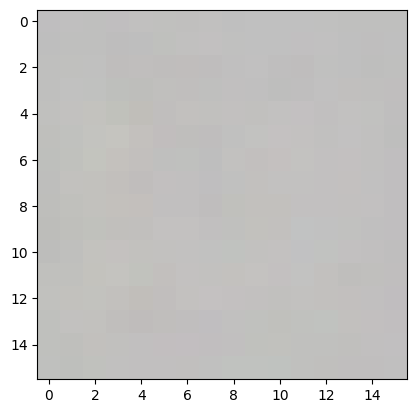

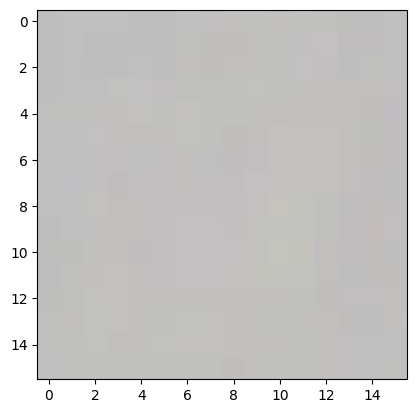

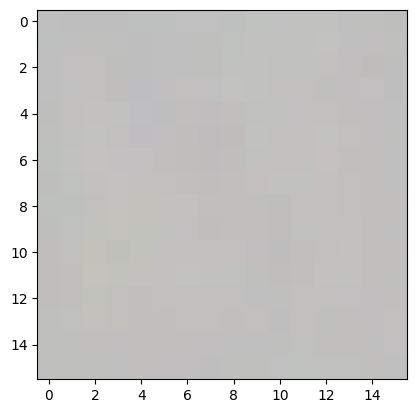

In [90]:
generator = build_generator()
img = generator.predict(np.random.randn(3, 128, 1))
print(img)
# img = img*255
# img = img.astype('uint8')
print('----------------------------')
print(img)
print(img.shape)
for index in range(0, 3):
  plt.imshow(img[index])
  plt.show()

In [91]:
discriminator = build_discriminator()
discriminator.predict(tf.random.normal((16, 16, 16, 4)))

1/1 [==============================] - 0s 29ms/step


array([[0.50237989],
       [0.48528898],
       [0.48318478],
       [0.49029940],
       [0.48825809],
       [0.48764864],
       [0.49838459],
       [0.49365604],
       [0.49755341],
       [0.49303302],
       [0.49540970],
       [0.49680665],
       [0.49800378],
       [0.49367613],
       [0.48981827],
       [0.50121379]], dtype=float32)

In [92]:
class MinecraftTextureGAN(Model):
  def __init__(self, generator, discriminator, batch_size, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.generator = generator
    self.discriminator = discriminator
    self.batch_size = batch_size

  def compile(self, g_loss, d_loss, g_optimizer, d_optimizer, *args, **kwargs):
    super().compile(*args, **kwargs)

    self.g_loss_f = g_loss
    self.d_loss_f = d_loss
    self.g_optimizer = g_optimizer
    self.d_optimizer = d_optimizer

    # self.g_optimizer.build(self.generator.trainable_variables)
    # self.d_optimizer.build(self.discriminator.trainable_variables)

  def train_step(self, batch_of_data):
    # train the discriminator
    with tf.GradientTape() as d_tape:
      real_img = batch_of_data
      # print(real_img.shape)

      # TODO: use this when the early is used
      self.batch_size = int(tf.shape(batch_of_data)[0].numpy())

      fake_img = generator(np.random.randn(self.batch_size, 128, 1), training=False)
      # print(fake_img.shape)

      real_and_fake_img = tf.concat([real_img, fake_img], axis=0)

      zeros = tf.zeros((self.batch_size, 1))
      random_arr = np.random.uniform(low=0.0, high=0.15, size=zeros.shape)
      zeros = zeros + random_arr

      ones = tf.ones((self.batch_size, 1))
      random_arr = np.random.uniform(low=0.0, high=0.15, size=ones.shape)
      ones = ones - random_arr

      real_and_fake_img_label = tf.concat([zeros, ones], axis=0)
      discriminator_prediction = self.discriminator(real_and_fake_img, training=True)
      # print(real_and_fake_img_label)
      # print(discriminator_prediction.shape)
      # print(real_and_fake_img_label.shape)
      real_and_fake_img_label = tf.squeeze(real_and_fake_img_label)
      discriminator_prediction = tf.squeeze(discriminator_prediction)

      d_loss = self.d_loss_f(real_and_fake_img_label, discriminator_prediction)
      # print(d_loss)

    d_gradient = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
    self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))

    # train the generator
    with tf.GradientTape() as g_tape:
      generated_images = self.generator(np.random.randn(self.batch_size, 128, 1), training=True)

      trick_discriminator_prediction = self.discriminator(generated_images, training=False)
      generated_label = tf.ones((self.batch_size, 1))
      # print(trick_discriminator_prediction.shape)
      # print(generated_label.shape)

      generated_label = tf.squeeze(generated_label)
      trick_discriminator_prediction = tf.squeeze(trick_discriminator_prediction)
      g_loss = self.g_loss_f(generated_label, trick_discriminator_prediction)
      # print(g_loss)

    g_gradient = g_tape.gradient(g_loss, self.generator.trainable_variables)
    self.g_optimizer.apply_gradients(zip(g_gradient, self.generator.trainable_variables))

    return {'generator_loss': g_loss, 'discriminator_loss': d_loss}


In [93]:
class Monitor(Callback):
  def __init__(self, num_img, seed_dim):
    super().__init__()
    self.num_img = num_img
    self.seed_dim = seed_dim

  def on_epoch_end(self, epoch, logs=None):
    img = self.model.generator.predict(np.random.randn(self.num_img, 128, 1))
    for i in range(self.num_img):
      image = array_to_img(img[i])
      image.save(os.path.join(f'images_{id}', f'texture_{epoch}_{i}.png'))



In [94]:
print(train_dataset)

<_ShuffleDataset element_spec=TensorSpec(shape=(None, 16, 16, 4), dtype=tf.float32, name=None)>


In [95]:
try:
  model_generator = load_model(f'minecraft_texture_generator_model_{id-1}.h5')
  model_discriminator = load_model(f'minecraft_texture_discriminator_model_{id-1}.h5')
  print(f"model id:{id-1} loaded")
except:
  model_generator = build_generator()
  model_discriminator = build_discriminator()
  print(f"no previous model, make new model")

g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00005)

model = MinecraftTextureGAN(model_generator, model_discriminator, 64)
model.compile(g_loss, d_loss, g_opt, d_opt)

# history = model.fit(train_dataset, epochs=50)

model id:1 loaded


In [ ]:
history = model.fit(x=train_dataset, epochs=100, callbacks=[Monitor(3, 128)])

Epoch 1/100
617/617 [==============================] - 179s 269ms/step - generator_loss: 0.0825 - discriminator_loss: 0.2699
Epoch 2/100
617/617 [==============================] - 116s 188ms/step - generator_loss: 0.0824 - discriminator_loss: 0.2686
Epoch 3/100
617/617 [==============================] - 115s 186ms/step - generator_loss: 0.0760 - discriminator_loss: 0.2692
Epoch 4/100
617/617 [==============================] - 115s 186ms/step - generator_loss: 0.0811 - discriminator_loss: 0.2684
Epoch 5/100
617/617 [==============================] - 116s 189ms/step - generator_loss: 0.0905 - discriminator_loss: 0.2688
Epoch 6/100
617/617 [==============================] - 116s 189ms/step - generator_loss: 0.0783 - discriminator_loss: 0.2679
Epoch 7/100
617/617 [==============================] - 116s 188ms/step - generator_loss: 0.0862 - discriminator_loss: 0.2754
Epoch 8/100
617/617 [==============================] - 118s 191ms/step - generator_loss: 0.0842 - discriminator_loss: 0.2691


In [ ]:
img = model_generator.predict(np.random.randn(1, 128, 1))
for i in range(1):
  image = array_to_img(img[i])
    # Check if the file exists
  if os.path.exists(f'images_{id}/texture_output.png'):
      # Delete the file
      os.remove(f'images_{id}/texture_output.png')
      print(f'File images/texture_output.png deleted.')
  else:
      print(f'File images/texture_output.png not found.')
  image.save(os.path.join(f'images_{id}', f'texture_output.png'))

In [ ]:
model_generator.save(f'minecraft_texture_generator_model_{id}.h5')
model_discriminator.save(f'minecraft_texture_discriminator_model_{id}.h5')

In [ ]:
print(history.history)
hist_df = pd.DataFrame(history.history)
hist_df.to_json(f'history_{id}.json')

In [ ]:
shutil.make_archive(f'images_{id}', 'zip', 'images_0')